In [1]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
DATA_PATH = 'data1/labeled_data.csv'
df = pd.read_csv('data1/labeled_data.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data1/labeled_data.csv'

<Axes: xlabel='class', ylabel='count'>

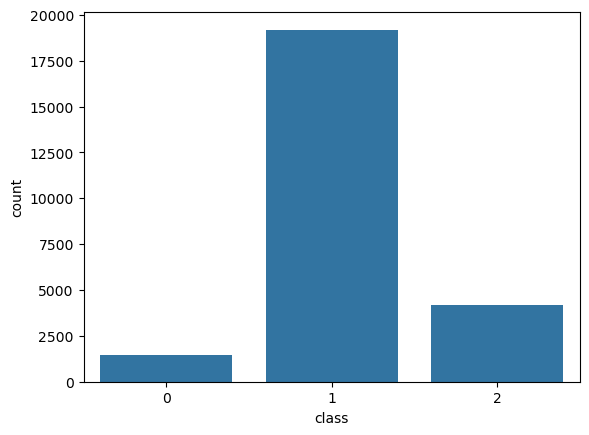

In [ ]:
sns.countplot(x='class', data=df)

In [ ]:
df['tweets_cleaned'] = df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweets_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [ ]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweets_cleaned'],
    num_rows: 24783
})

In [ ]:
dataset = load_dataset('csv', data_files=DATA_PATH, split='train')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [ ]:
train_test_valid = ds.train_test_split()
test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict(
    {
        'train':train_test_valid['train'],
        'test':test_valid['test'],
        'valid':test_valid['train']

    }
)

In [ ]:
dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither', 'Unnamed: 0', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned'],
        num_rows: 4647
    })
})

## tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
text = 'hi this is ramsaheb'

output = tokenizer(text)

output

{'input_ids': [101, 20844, 1142, 1110, 26084, 3202, 4638, 1830, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'hi', 'this', 'is', 'ram', '##sa', '##he', '##b', '[SEP]']

In [ ]:
print(f'vocab size is: {tokenizer.vocab_size}')
print(f'model max len: {tokenizer.model_max_length}')
print(f'model input name are: {tokenizer.model_input_names}')

vocab size is: 28996
model max len: 512
model input name are: ['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
def tokenize_func(train_dataset):
    return tokenizer(train_dataset['tweets_cleaned'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

train_dataset = tokenized_dataset['train']
test_dataset = tokenized_dataset['test']
valid_dataset = tokenized_dataset['valid']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweets_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4647
    })
})

In [ ]:
train_dataset = train_dataset.remove_columns(['tweet', 'tweets_cleaned']).with_format('tensorflow')
test_dataset = test_dataset.remove_columns(['tweet', 'tweets_cleaned']).with_format('tensorflow')
valid_dataset = valid_dataset.remove_columns(['tweet', 'tweets_cleaned']).with_format('tensorflow')

In [ ]:
train_dataset

Dataset({
    features: ['class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [ ]:
train_features = {x:train_dataset[x] for x in tokenizer.model_input_names}
train_dataset_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_dataset['class']))
train_dataset_for_final_model = train_dataset_for_final_model.shuffle(len(train_dataset)).batch(8)

test_features = {x:test_dataset[x] for x in tokenizer.model_input_names}
test_dataset_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, test_dataset['class']))
test_dataset_for_final_model = test_dataset_for_final_model.shuffle(len(test_dataset)).batch(8)

valid_features = {x:valid_dataset[x] for x in tokenizer.model_input_names}
valid_dataset_for_final_model = tf.data.Dataset.from_tensor_slices((valid_features, valid_dataset['class']))
valid_dataset_for_final_model = valid_dataset_for_final_model.shuffle(len(valid_dataset)).batch(8)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_dataset_for_final_model, validation_data=valid_dataset_for_final_model, epochs=3)

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset_for_final_model, verbose=2)
print('test acc: ', test_acc)

In [ ]:
predict_score_and_class_dict = {
    0:'hate speech',
    1:'offensive lang',
    2:'neither'
}

preds = model(tokenizer(['he is motherfucker', 'son of a bitch'], return_tensors='tf',
                        padding=True, truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
    print(predict_score_and_class_dict[pred])